In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [18]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.6, random_state=0)
X = X[:, ::-1]

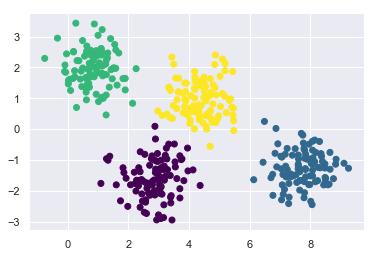

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels, cmap = 'viridis')

In [20]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_cluster=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    #plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c = labels, s=40, cmap = 'viridis', zorder = 2)
    
    #plot the representation pf the model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, lw = 3, alpha = 0.5, zorder =1))
        
        

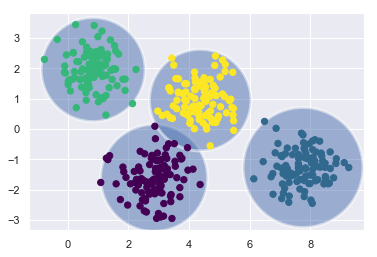

In [21]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

This is limitation. Always circle. K-Means can not work with another distribution

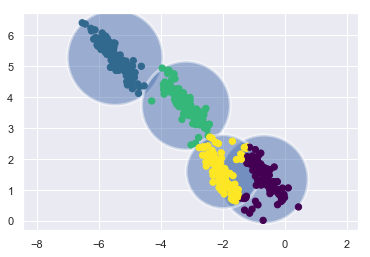

In [22]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

### Generalizing E-M. Gaussian Mixture Model

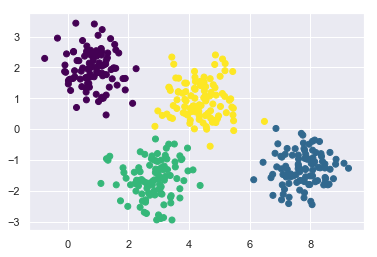

In [23]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels, cmap = 'viridis')

**BUT** because GMM contains probabilistic model under the hood. We can find prob cluster assignments

In [24]:
probs = gmm.predict_proba(X)
print(probs[:5].round(2))

[[0.   0.46 0.   0.54]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]]


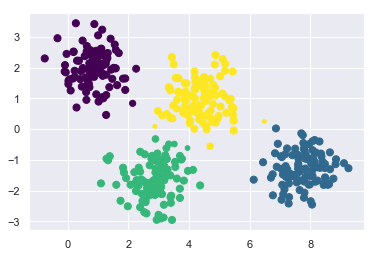

In [25]:
size  = (50*probs.max(1) ** 2)
plt.scatter(X[:,0], X[:, 1], c = labels, cmap = 'viridis', s  = size)

#### Algorithm GMM
- Choose starting guesses for location and shape
- Repeat untill converged
    - *E-step*: for each point, find thw weights encoding the probability of membership in each cluster
    - *M-step*: for each cluster, update its location, normalization, and shape based on all data points


In [26]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax =None, **kwargs):
    """draw an ellipsa with a given position and covariance"""
    ax = ax or plt.gca()
    
    #Convert covariance to principal component
    if covariance.shape ==(2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig *width, nsig* height,
                            angle, **kwargs))
        
def plot_gmm(gmm, X, label = True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c = labels, s =40 , cmap = 'viridis', zorder =2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_ , gmm.weights_):
        draw_ellipse(pos, covar, alpha=2*w*w_factor)

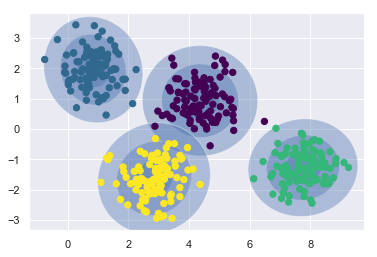

In [27]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)


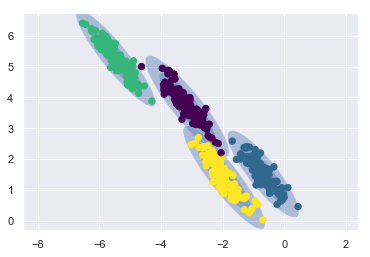

In [28]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)


### GMM as Density Estimation

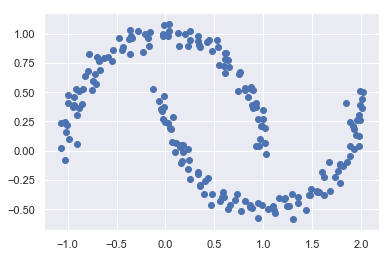

In [48]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise = 0.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

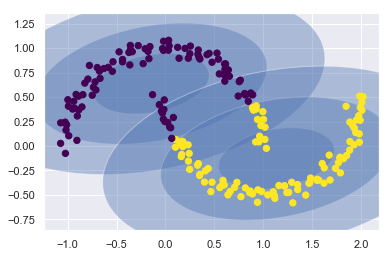

In [57]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)


(-1.5, 2.5)

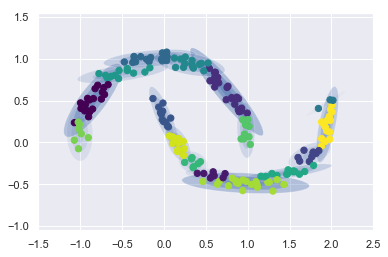

In [58]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon)
plt.xlim(-1.5, 2.5)

There is a good way. We can use a lot components for describing data  

GMM gives us recipe to generate new random data distributed similarly to our input

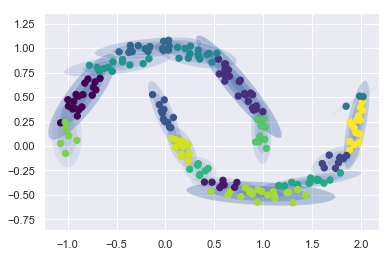

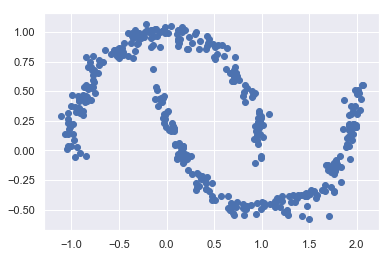

In [83]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon)
plt.figure()
Xnew, ynew = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

#### How many components we need ?

### Example: GMM for Generating New Data


In [88]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [100]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize = (10,10),
                           subplot_kw = dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i, axi in enumerate(ax.flat):
        ix = axi.imshow(data[i].reshape(8,8), cmap = 'binary')
        ix.set_clim(0,16)
        


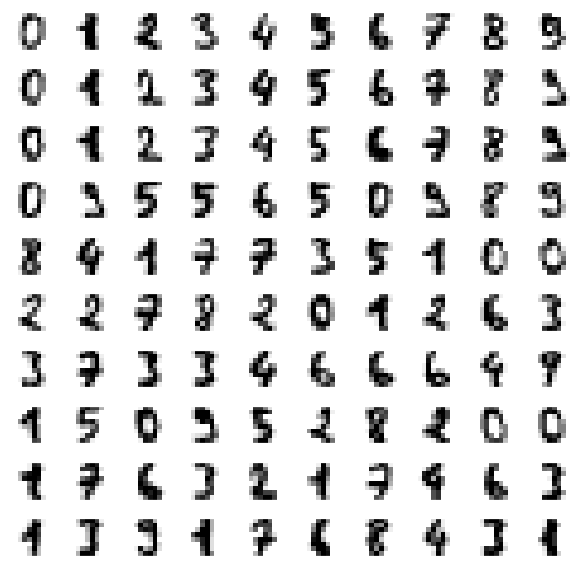

In [101]:
plot_digits(digits.data)

It is very difficult to use GMM on 64-dimensial data. So we firstly use PCA preserbing 0.99 variance

In [121]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

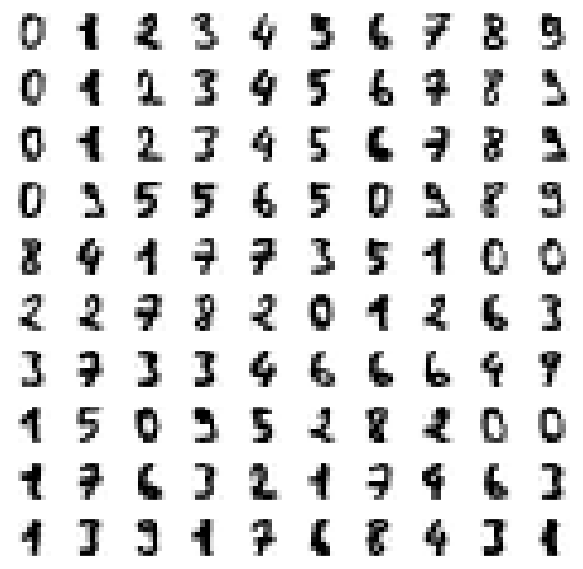

In [122]:
plot_digits(pca.inverse_transform(data))

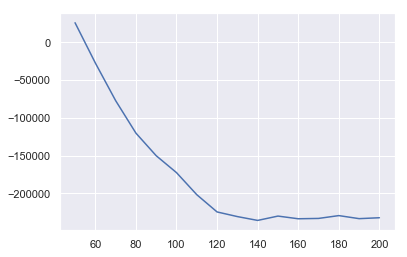

In [123]:
### Estimate n_components of GMM for describing data
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
              for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

In [127]:
gmm = GMM(n_components=110, covariance_type='full', random_state=0)
gmm.fit(data)
data_new, ynew = gmm.sample(100)
data_new.shape

(100, 41)

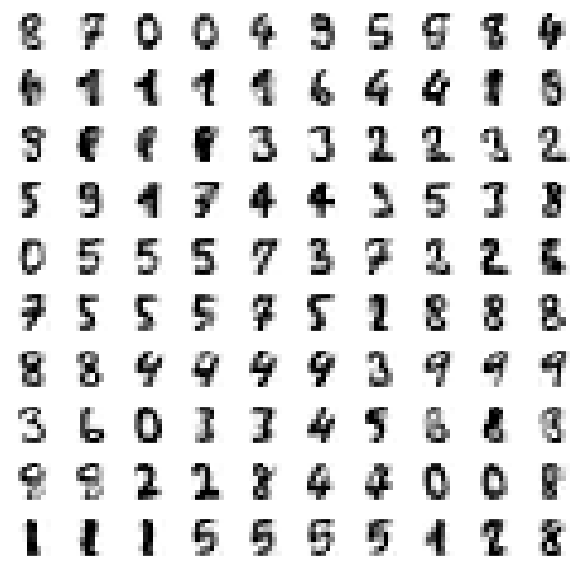

In [128]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

### Example 2: Generate faces

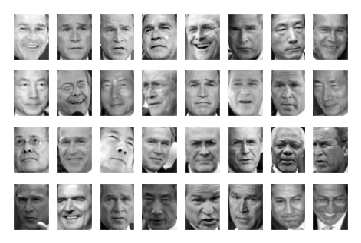

In [138]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape
faces.images.shape

def plot_faces(data):
    fig, ax = plt.subplots(4,8, subplot_kw=dict(xticks=[], yticks=[]))
    for i, axi in enumerate(ax.flat):
        axi.imshow(data[i].reshape(62, 47), cmap='gray')
        
plot_faces(faces.data)

In [142]:
gmm = GMM(n_components=110, covariance_type='full', random_state=0, verbose = 1)
gmm.fit(faces.data[:500])
face_new, ynew = gmm.sample(100)
plot_faces(face_new)

Initialization 0


MemoryError: 

In [ ]:
### Estimate n_components of GMM for describing data
n_components = np.arange(70, 300, 20)
models = [GMM(n, covariance_type='full', random_state=0)
              for n in n_components]
aics = [model.fit(faces.data).aic(faces.data) for model in models]
plt.plot(n_components, aics)